# Image Super-Resolution Inference (SRResNet/SRGAN)

This is notebook is for inference of the models found in the [Image-Super-Resolution-using-GANs](https://github.com/rafipatel/Image-Super-Resolution-using-GANs/) Github repository.

Download our checkpoints [here](https://cityuni-my.sharepoint.com/:f:/g/personal/yasir-zubayr_barlas_city_ac_uk/EvPZOvxznetMi6MV3iN40JsBosC_QSkUhjvD464jKtUYrg?e=barQWp).

### Import Libraries and Checkpoints

In [1]:
# Import relevant libraries

import torch
from utils import *
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from models import *

In [2]:
# Note that you need both an SRResNet and an SRGAN checkpoint downloaded
# Download our checkpoints here: https://cityuni-my.sharepoint.com/:f:/g/personal/yasir-zubayr_barlas_city_ac_uk/EvPZOvxznetMi6MV3iN40JsBosC_QSkUhjvD464jKtUYrg?e=barQWp
# In other words, download 'checkpoint_srresnet.pth.tar' from 'Our SRResNet (version in report)' and 'checkpoint_srgan.pth.tar' from 'Our SRGAN (version in report)'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model checkpoints (change as necessary to the correct checkpoint paths)
srgan_checkpoint = "checkpoints/checkpoint_srgan.pth.tar"
srresnet_checkpoint = "checkpoints/checkpoint_srresnet.pth.tar"

In [3]:
# Load SRResNet (Our SRResNet)
# You should have the SRResNet checkpoint correct downloaded
net = SRResNet(large_kernel_size = 9, small_kernel_size = 5, n_channels = 64, n_blocks = 20, scaling_factor = 4, activation = "GELU", enable_standard_bn = False, resid_scale_factor = "none", self_attention = False)
srresnet = torch.load(srresnet_checkpoint, map_location = device)["model"].to(device)
net.load_state_dict(srresnet.state_dict())
srresnet = net.to(device)
srresnet.eval()

# Load SRGAN (Our SRGAN)
# You should only have the SRGAN checkpoint downloaded and not the SRResNet checkpoint that comes with it (the SRResNet checkpoint was the pre-trained generator)
net = Generator(large_kernel_size = 9, small_kernel_size = 5, n_channels = 64, n_blocks = 16, scaling_factor = 4, activation = "GELU", enable_standard_bn = False, resid_scale_factor = 0.1, self_attention = True)
srgan_generator = torch.load(srgan_checkpoint, map_location = device)["generator"].to(device)
net.load_state_dict(srgan_generator.state_dict())
srgan_generator = net.to(device)
srgan_generator.eval()

Generator(
  (net): SRResNet(
    (conv_block1): ConvolutionalBlock(
      (conv_block): Sequential(
        (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
        (1): GELU(approximate='none')
      )
    )
    (residual_blocks): Sequential(
      (0): ResidualBlock(
        (conv_block1): ConvolutionalBlock(
          (conv_block): Sequential(
            (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
            (1): GELU(approximate='none')
          )
        )
        (conv_block2): ConvolutionalBlock(
          (conv_block): Sequential(
            (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
          )
        )
      )
      (1): ResidualBlock(
        (conv_block1): ConvolutionalBlock(
          (conv_block): Sequential(
            (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
            (1): GELU(approximate='none')
          )
        )
        (conv_block2): ConvolutionalBl

### Generate Super-Resolved Images

In [4]:
def visualise_sr(img, halve = False):
    """
    Visualises the super-resolved images from the SRResNet and SRGAN for comparison with the bicubic-upsampled image
    and the original high-resolution (HR) image, as done in the paper.

    img: filepath of the HR image
    halve: halve each dimension of the HR image to make sure it"s not greater than the dimensions of your screen?
                  For instance, for a 2160p HR image, the LR image will be of 540p (1080p/4) resolution. On a 1080p screen,
                  you will therefore be looking at a comparison between a 540p LR image and a 1080p SR/HR image because
                  your 1080p screen can only display the 2160p SR/HR image at a downsampled 1080p. This is only an
                  APPARENT rescaling of 2x.
                  If you want to reduce HR resolution by a different extent, modify accordingly.
    """
    # Load image, downsample to obtain low-res version
    hr_img = Image.open(img, mode = "r")
    hr_img = hr_img.convert("RGB")

    if halve:
        hr_img = hr_img.resize((int(hr_img.width / 2), int(hr_img.height / 2)), Image.LANCZOS)

    lr_img = hr_img.resize((int(hr_img.width / 4), int(hr_img.height / 4)), Image.BICUBIC)

    # Bicubic Upsampling
    bicubic_img = lr_img.resize((hr_img.width, hr_img.height), Image.BICUBIC)

    # Super-resolution (SR) with SRResNet
    sr_img_srresnet = srresnet(convert_image(lr_img, source = "pil", target = "imagenet-norm").unsqueeze(0).to(device))
    sr_img_srresnet = sr_img_srresnet.squeeze(0).cpu().detach()
    sr_img_srresnet = convert_image(sr_img_srresnet, source = "[-1, 1]", target = "pil")

    # Super-resolution (SR) with SRGAN
    sr_img_srgan = srgan_generator(convert_image(lr_img, source = "pil", target = "imagenet-norm").unsqueeze(0).to(device))
    sr_img_srgan = sr_img_srgan.squeeze(0).cpu().detach()
    sr_img_srgan = convert_image(sr_img_srgan, source = "[-1, 1]", target = "pil")

    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    # Plot bicubic-upsampled image
    axs[0].imshow(bicubic_img)
    axs[0].axis("off")
    axs[0].set_title("Bicubic", fontsize = 24)

    # Plot SRResNet image
    axs[1].imshow(sr_img_srresnet)
    axs[1].axis("off")
    axs[1].set_title("SRResNet", fontsize = 24)

    # Plot SRGAN image
    axs[2].imshow(sr_img_srgan)
    axs[2].axis("off")
    axs[2].set_title("SRGAN", fontsize = 24)

    # Plot original HR image
    axs[3].imshow(hr_img)
    axs[3].axis("off")
    axs[3].set_title("Original HR", fontsize = 24)

    plt.tight_layout()
    plt.savefig("combined_images.pdf")
    plt.show()

In [5]:
def visualise_individual_sr(img, halve = False):
    """
    Visualises the super-resolved images from the SRResNet and SRGAN for comparison with the bicubic-upsampled image
    and the original high-resolution (HR) image, as done in the paper.

    img: filepath of the HR image
    halve: halve each dimension of the HR image to make sure it"s not greater than the dimensions of your screen?
                  For instance, for a 2160p HR image, the LR image will be of 540p (1080p/4) resolution. On a 1080p screen,
                  you will therefore be looking at a comparison between a 540p LR image and a 1080p SR/HR image because
                  your 1080p screen can only display the 2160p SR/HR image at a downsampled 1080p. This is only an
                  APPARENT rescaling of 2x.
                  If you want to reduce HR resolution by a different extent, modify accordingly.
    """
    # Load image, downsample to obtain low-res version
    hr_img = Image.open(img, mode = "r")
    hr_img = hr_img.convert("RGB")

    if halve:
        hr_img = hr_img.resize((int(hr_img.width / 2), int(hr_img.height / 2)), Image.LANCZOS)

    lr_img = hr_img.resize((int(hr_img.width / 4), int(hr_img.height / 4)), Image.BICUBIC)

    # Bicubic Upsampling
    bicubic_img = lr_img.resize((hr_img.width, hr_img.height), Image.BICUBIC)

    # Super-resolution (SR) with SRResNet
    sr_img_srresnet = srresnet(convert_image(lr_img, source = "pil", target = "imagenet-norm").unsqueeze(0).to(device))
    sr_img_srresnet = sr_img_srresnet.squeeze(0).cpu().detach()
    sr_img_srresnet = convert_image(sr_img_srresnet, source = "[-1, 1]", target = "pil")

    # Super-resolution (SR) with SRGAN
    sr_img_srgan = srgan_generator(convert_image(lr_img, source = "pil", target = "imagenet-norm").unsqueeze(0).to(device))
    sr_img_srgan = sr_img_srgan.squeeze(0).cpu().detach()
    sr_img_srgan = convert_image(sr_img_srgan, source = "[-1, 1]", target = "pil")

    # Plot bicubic-upsampled image
    plt.imshow(bicubic_img)
    plt.axis("off")
    plt.title("Bicubic", fontsize = 24)
    plt.savefig("individual_bicubic.pdf")
    plt.show()

    # Plot SRResNet image
    plt.imshow(sr_img_srresnet)
    plt.axis("off")
    plt.title("SRResNet", fontsize = 24)
    plt.savefig("individual_srresnet.pdf")
    plt.show()

    # Plot SRGAN image
    plt.imshow(sr_img_srgan)
    plt.axis("off")
    plt.title("SRGAN", fontsize = 24)
    plt.savefig("individual_srgan.pdf")
    plt.show()

    # Plot original HR image
    plt.imshow(hr_img)
    plt.axis("off")
    plt.title("Original HR", fontsize = 24)
    plt.savefig("individual_hr.pdf")
    plt.show()

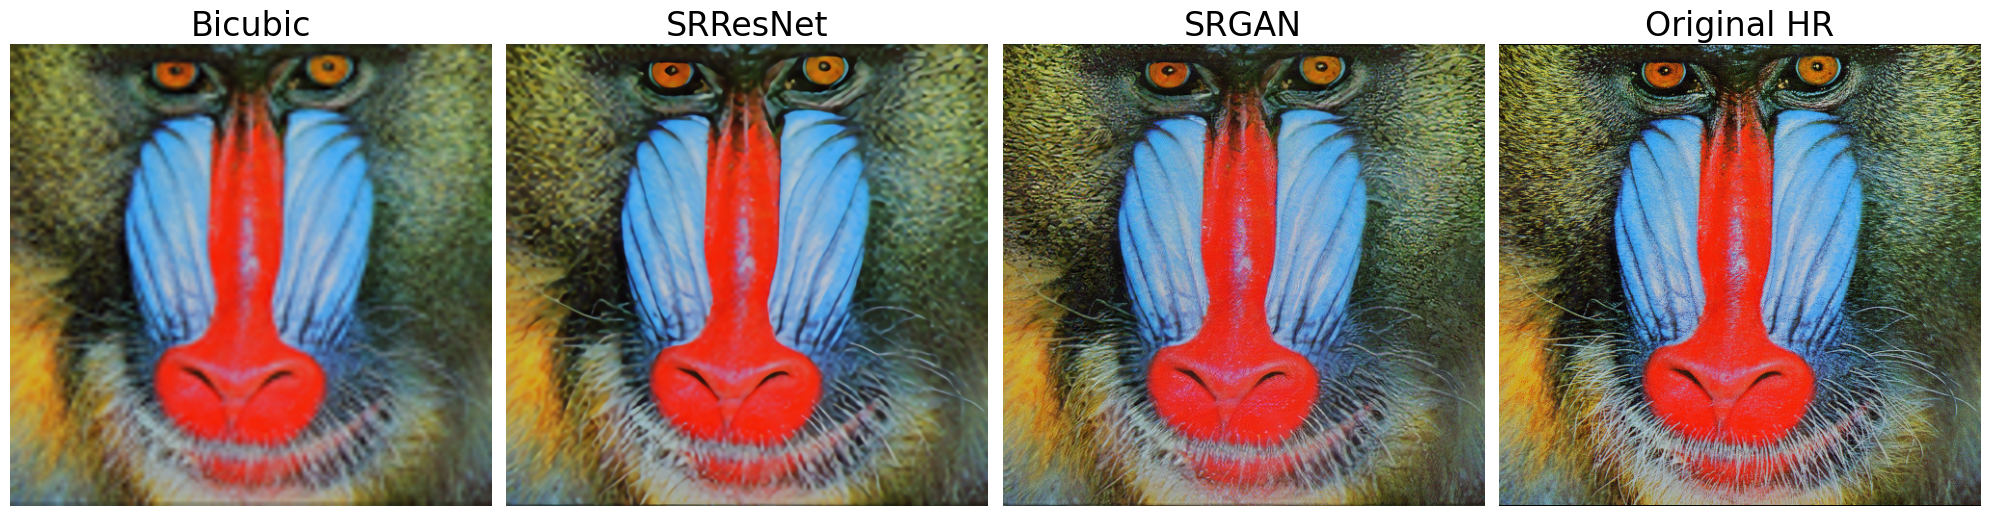

In [6]:
# Visualise results of SRResNet and SRGAN models, compared to bicubic interpolation and the HR image
# The path to a HR image needs to be entered into the function
# Results shown in a single plot
visualise_sr("../Set14/baboon.png")

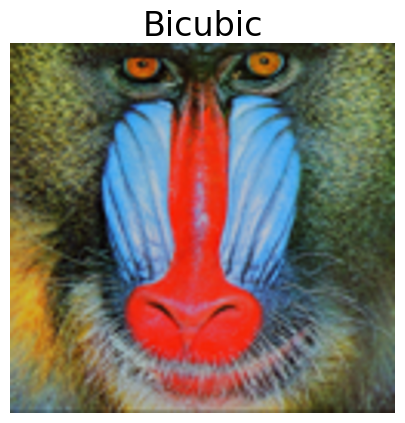

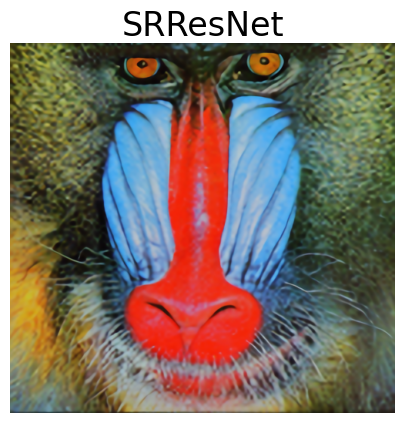

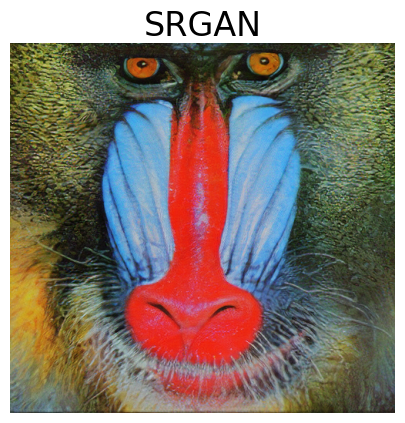

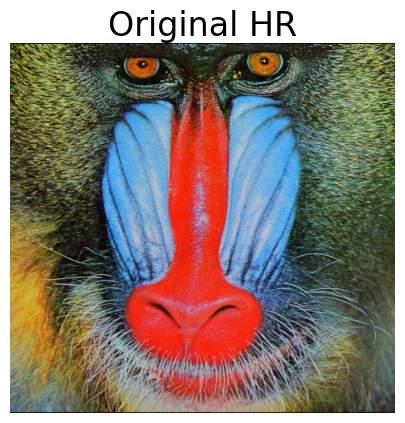

In [7]:
# Visualise results of SRResNet and SRGAN models, compared to bicubic interpolation and the HR image
# The path to a HR image needs to be entered into the function
# Results shown in separate plots
visualise_individual_sr("../Set14/baboon.png")